In [5]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embedding_generation import EmbeddingGenerator, NLI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
wiki_dataset = WikiDataset(reduced=True, in_mem=True, num_extra_pages=0, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False)

In [3]:
emb_gen = EmbeddingGenerator()
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker')

Creating collection
Block 1/2 done
Block 2/2 done
Time to create collection: 39.71009063720703


In [11]:
fever_collator = FeverCollator()
fever_dataset = FeverDataset(type='eval')
fever_loader = DataLoader(fever_dataset, batch_size=32, num_workers=10, shuffle=False, collate_fn=fever_collator)

emb_gen = EmbeddingGenerator()
nli = NLI()

In [1]:
import torch
from train_eval_utils import get_target_changes, get_negative_examples
import time
import numpy as np

PAGES_RETRIEVED = 50
PAGES_FOR_EVIDENCE = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn1 = torch.nn.CosineEmbeddingLoss()
loss_fn2 = torch.nn.BCELoss()

# get embeddings of the claims
emb_gen.eval()
nli.eval()

for i, input_batch in enumerate(fever_loader):
    if i == 1:
        break
    batch_size = len(input_batch['claims'])
    init = time.time()
    with torch.no_grad():
        outputs = emb_gen(input_batch['claims'])

    print('Embedding generation time:', (time.time() - init)*1000, 'ms')

    init = time.time()
    # search for similar pages
    similar_pages = vdb.search_similar(outputs, PAGES_RETRIEVED, with_payload=True)
    print('   Search time:', (time.time() - init)*1000, 'ms')

    similar_texts = []
    similar_ids = []
    for s in similar_pages:
        similar_texts.append([t.payload['text'] for t in s])
        similar_ids.append([t.payload['id'] for t in s])

    target_changes, percentage_retrieved = get_target_changes(input_batch['evidence'], similar_ids, PAGES_FOR_EVIDENCE)
    origibal_nli_targets = [int(v == 'VERIFIABLE') for v in input_batch['verifiable']]

    # dinamically change the target
    #---------------------------------- only training
    dynamic_nli_targets = [int(t and tc) for t, tc in zip(origibal_nli_targets, target_changes)]
    #---------------------------------- only training

    all_evidence = [r['all_evidence'] if r['all_evidence'] != [None] else [] for r in input_batch['evidence']]
    init2 = time.time()
    evidence_pages = [vdb.search_ids(all_evidence[i]) for i in range(batch_size)]
    print('   Evidence search time:', (time.time() - init2)*1000, 'ms')
    evidence_texts = [[t.payload['text'] for t in s] for s in evidence_pages]
    # pick as negative examples the texts of the last len(evidence_texts) of the 50 retrieved pages
    negative_examples = get_negative_examples(similar_texts, similar_ids, all_evidence)

    print('Retrieval time:', (time.time() - init)*1000, 'ms')
    init = time.time()
    # combine all the batches
    unfolded_outputs = []
    unfolded_combined_texts = []
    unfolded_labels = []
    for i in range(batch_size):
        unfolded_outputs.extend([outputs[i]] * (len(evidence_texts[i]) + len(negative_examples[i])))
        unfolded_combined_texts.extend(evidence_texts[i] + negative_examples[i])
        unfolded_labels.extend([1] * len(evidence_texts[i]) + [0] * len(negative_examples[i]))

    # encode the combined texts in batches
    combined_embeddings = []
    for i in range(0, len(unfolded_combined_texts), batch_size):
        with torch.no_grad():
            combined_embeddings.extend(emb_gen(unfolded_combined_texts[i:i+batch_size]))


    combined_embeddings = torch.stack(combined_embeddings)
    unfolded_outputs = torch.stack(unfolded_outputs)
    unfolded_labels = torch.tensor(np.array(unfolded_labels)).to(device)

    loss1 = loss_fn1(combined_embeddings, unfolded_outputs, unfolded_labels)

    print('Re embedding generation time:', (time.time() - init)*1000, 'ms')
    init = time.time()

    # input for the NLI model
    
    similar_embeddings = vdb.search_similar(outputs, PAGES_FOR_EVIDENCE, with_vector=True)
    similar_embeds = [[t.vector for t in s] for s in similar_embeddings]
    print('   Similar search time:', (time.time() - init)*1000, 'ms')
    similar_embeds = torch.tensor(np.array(similar_embeds), dtype=torch.float32).to(device)
    outputs = outputs.unsqueeze(1)

    # concat the output of the embedding generator
    nli_inputs = torch.cat([outputs, similar_embeds], dim=1)

    init2 = time.time()
    with torch.no_grad():
        nli_outputs = nli(nli_inputs)

    init2 = time.time()
    preds = torch.argmax(nli_outputs, dim=1).cpu().numpy()
    targets = torch.tensor(dynamic_nli_targets, dtype=torch.float32).to(device)

    nli_outputs = nli_outputs.squeeze()
    # Convert lists of tensors to tensors
    loss2 = loss_fn2(nli_outputs, targets)

    print('NLI time:', (time.time() - init)*1000, 'ms')
    
    result = {'preds': preds, 
              'original_labels': origibal_nli_targets, 
              'dynamic_labels': dynamic_nli_targets, 
              'percentage_retrieved': percentage_retrieved,
              'loss1': loss1.item(),
              'loss2': loss2.item()}

    print(result)

NameError: name 'emb_gen' is not defined

## Real

In [3]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embedding_generation import EmbeddingGenerator, NLI
from validation import Validation
from train import Train
import torch
from other_utils import print_progress

N_EPOCHS = 10
B = 0.1
NUM_EXTRA_PAGES = 50000

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=10, num_workers=8, shuffle=True, collate_fn=fever_collator)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, batch_size=64, num_workers=8, shuffle=False, collate_fn=fever_collator)
wiki_dataset = WikiDataset(reduced=True, in_mem=True, num_extra_pages=NUM_EXTRA_PAGES, seed=None)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=8196, num_workers=8, shuffle=False)

emb_gen = EmbeddingGenerator()
nli = NLI()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.5)
loss_fn2 = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(nli.parameters()), lr=1e-3)#list(emb_gen.parameters()) + 

tracking_eval = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [], 
                'nli_f1': [], 
                'overall_accuracy': [], 
                'overall_f1': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [], 
                'average_loss2':  [],
                'average_total_loss': []}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
train_fever_loader = DataLoader(train_fever_dataset, batch_size=30, num_workers=8, shuffle=True, collate_fn=fever_collator)

Epoch: 0
Batch: 1/1


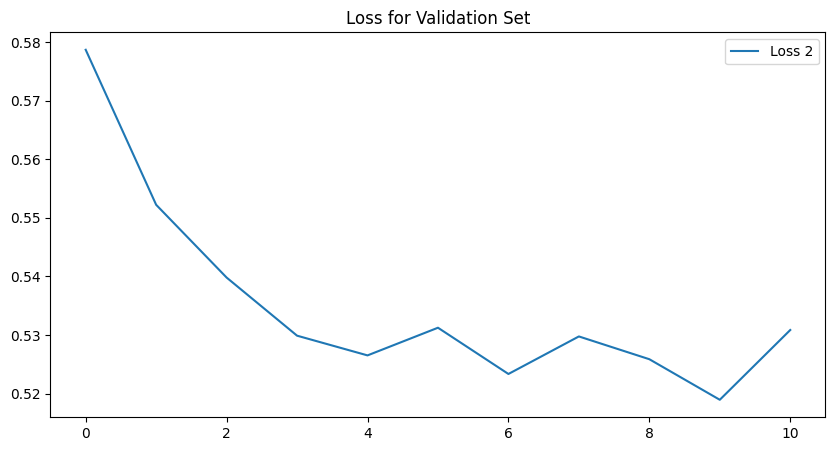

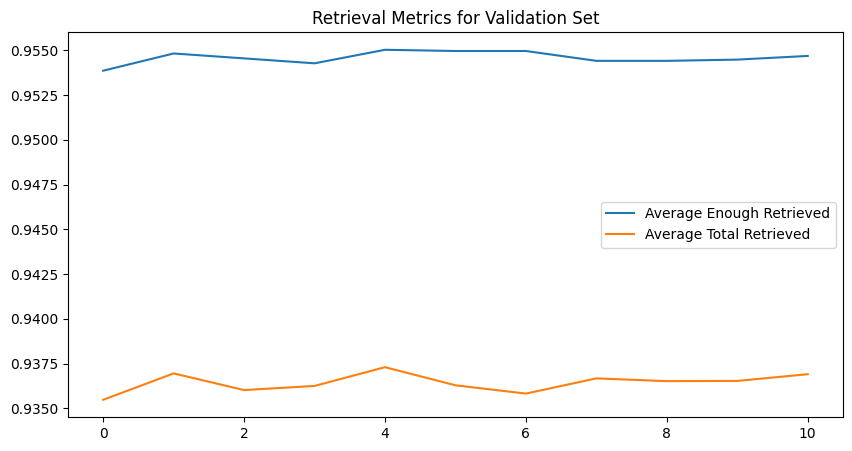

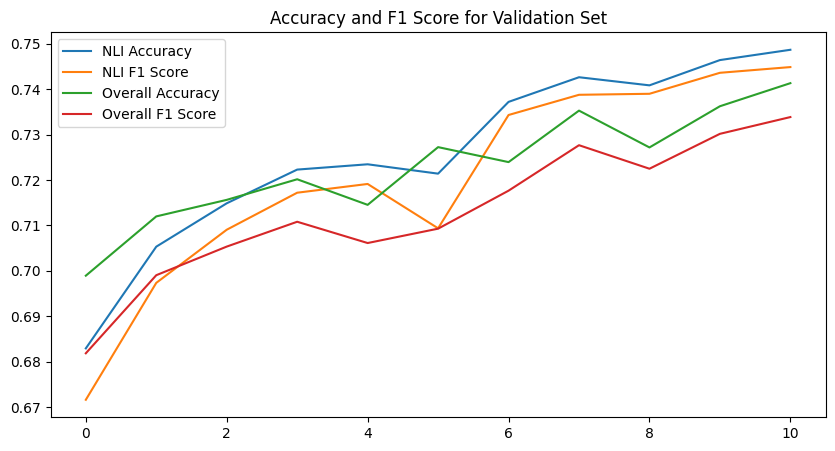

Creating collection
Block 1/8 done
Block 2/8 done
Block 3/8 done
Block 4/8 done
Block 5/8 done
Block 6/8 done
Block 7/8 done
Block 8/8 done
Time to create collection: 116.84574103355408


In [6]:
val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, B=B, model_name='test')
train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, B=B, optimizer=optimizer, model_name='test')

vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker')
#val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=None)
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=10, vdb_refresh_rate=5000)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=0.1)
    val.valid_epoch(vdb=vdb, emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_eval=tracking_eval, ma_ratio=0.1)
    vdb.refresh(emb_gen)

In [ ]:
# sva the NLI model
torch.save(nli.state_dict(), 'models/nli_v0.pth')

In [20]:
# saVE dicts tracking to file, create if file does not exist
import json
with open('results/NLI_v0/tracking_train_v0.json', 'w') as f:
    json.dump(tracking_train, f)
